# COVID-19 Case Study With *Troppo*

The goal of this case study is to explore metabolic interactions between SARS-CoV-2 and its host during infection. 
To achieve this, bulk RNA-seq data will be used to reconstruct context-specific models of several healthy and infected tissues.
The transcriptomics data will be integrated into the [Human-GEM](https://github.com/SysBioChalmers/Human-GEM/tree/main) model using the FastCORE algorithm.

The dataset selected for this case study is comprised of two distinct datasets:

1. **[GEO: GSE150316](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE150316)**: This dataset is from the study titled *"Temporal and spatial heterogeneity of host response to SARS-CoV-2 pulmonary infection"* by Desai and colleagues. It includes analyses of autopsy specimens from 24 COVID-19 patients, with samples collected from various tissues. However, this study lacks healthy samples for contrast with the infected tissues.

2. **[*Genotype-Tissue Expression (GTEx)* Portal](https://gtexportal.org/home/)**: To supplement the lack of healthy samples, data from the GTEx Portal was used. This dataset includes data from several non-diseased tissues.

The intersection of tissues found in both datasets was used, namely: lung, heart, kidney, liver, and intestine.
This [dataset](https://github.com/BioSystemsUM/troppo/blob/master/tests/data/Desai-GTEx_ensembl.csv) and [model](https://github.com/BioSystemsUM/troppo/blob/master/tests/data/HumanGEM_Consistent_COVID19_HAM.xml) used here are available for download in *Troppo's* github page.

### Pipeline Overview

The pipeline employed for this case study will follow these steps:

1. **Initial Setup**: Load the dataset and model.

2. **Gene-Level Thresholding**: Calculate Transcript Activity Scores (TAS) using the `GeneLevelThresholding`class.

3. **Run FastCORE**: Use *Troppo's* FastCORE algorithm for multiple samples with the `run_from_omics` function of the `ReconstructionWrapper` class.

### 1. Initial Setup

##### Required Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cobra.io import read_sbml_model
import re

from troppo.omics.readers.generic import TabularReader
from troppo.methods_wrappers import ReconstructionWrapper
from cobamp.utilities.parallel import batch_run
from troppo.omics import GeneLevelThresholding

C:\Users\biosy\anaconda3\envs\troppo\lib\site-packages\cobamp-0.2.1-py3.8.egg\cobamp\wrappers\external_wrappers.py:9: UserWarning: 
The wrappers.external_wrappers module will be deprecated in a future release in favour of the wrappers module. 
    Available ModelObjectReader classes can still be loaded using cobamp.wrappers.<class>. An appropriate model 
    reader can also be created using the get_model_reader function on cobamp.wrappers
  warnings.warn(


##### Load the model

In [2]:
model = read_sbml_model('HumanGEM_Consistent_COVID19_HAM.xml')
model

Name,HumanGEM
Memory address,21b2f57c670
Number of metabolites,6149
Number of reactions,10347
Number of genes,2976
Number of groups,142
Objective expression,1.0*biomass_human - 1.0*biomass_human_reverse_fb2f2
Compartments,"Cytosol, Lysosome, Endoplasmic reticulum, Extracellular, Mitochondria, Peroxisome, Golgi apparatus, Nucleus, Inner mitochondria"


Note that for this study we are using a modified version of the HumanGEM model. Three main changes were performed:

- **Environmental Conditions**: The model's environmental conditions were altered to represent a HAM medium.

- **Viral Biomass Objective Function**: Added a viral biomass objective function to model SARS-CoV-2 replication.

- **Create a Consistent Model**: Blocked reactions were removed to create a consistent model. This step simplified the model and ensured consistency, as required by the *FastCORE* algorithm. Blocked reactions were identified using the `find_blocked_reactions` function from COBRApy, which utilizes *Flux Variability Analysis (FVA)* to detect reactions with no flux. After identifying the blocked reactions, they were removed, resulting in a consistent model.


##### Load the omics data

In [3]:
omics_data = pd.read_csv(filepath_or_buffer='Desai-GTEx_ensembl.csv', index_col=0)
omics_data

,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001461,ENSG00000001497,ENSG00000001561,...,ENSG00000271321,ENSG00000271605,ENSG00000272047,ENSG00000272325,ENSG00000272333,ENSG00000272414,ENSG00000272573,ENSG00000272968,ENSG00000273045,ENSG00000273079
ensembl_gene_id,,,,,,,,,,,,,,,,,,,,,
Lung_Healthy,5.022368,0.584963,6.444601,6.213347,4.822730,3.000000,3.776104,3.336283,4.343408,3.722466,...,0.137504,3.070389,1.847997,3.432959,2.944858,3.350497,5.074677,0.378512,0.847997,0.000000
Lung_COVID19,2.988018,1.551051,5.777630,7.134232,4.429446,3.593211,4.770509,3.824891,3.566066,4.433298,...,0.000000,4.669531,2.331411,3.326899,4.985126,4.696205,0.000000,0.000000,0.000000,0.381678
Heart_Healthy,4.498251,0.263034,2.232661,7.360189,3.906891,2.035624,2.510962,2.485427,3.446256,2.765535,...,0.000000,1.485427,1.807355,2.655352,1.678072,3.510962,6.238405,0.000000,0.137504,0.000000
Heart_COVID19,1.853724,0.000000,3.443118,4.658543,2.425952,2.840368,1.938861,3.244538,1.761493,3.183750,...,0.000000,2.119085,1.319589,3.271281,4.353896,5.244192,0.000000,0.000000,0.000000,0.190673
Liver_Healthy,4.193772,0.584963,2.378512,8.166916,4.017922,3.765535,2.459432,1.263034,3.185867,1.678072,...,0.000000,0.584963,1.321928,2.035624,1.632268,4.129283,2.432959,0.137504,0.263034,0.000000
Liver_COVID19,0.000000,0.511386,1.701718,5.943322,3.150758,2.842919,2.988525,1.018353,1.549280,1.718309,...,0.000000,0.000000,1.475532,2.285016,3.281417,4.870318,0.000000,0.000000,0.000000,0.909254
Kidney_Healthy,4.426265,0.378512,2.432959,4.329124,4.439623,2.827819,2.744161,2.906891,3.678072,2.744161,...,0.000000,1.321928,1.887525,2.655352,2.292782,1.321928,3.817623,0.137504,1.584963,0.000000
Kidney_COVID19,0.000000,0.000000,3.357754,4.169963,2.935908,1.484950,2.975813,2.236568,2.772069,1.231109,...,0.000000,1.648199,0.596815,2.297268,3.402046,2.763531,0.000000,0.000000,2.014589,0.000000
Intestine_Healthy,4.887525,0.678072,3.201634,5.422906,4.638074,4.053111,3.307429,3.321928,4.153805,2.847997,...,0.000000,2.232661,1.584963,2.786596,2.944858,3.643856,4.689299,0.263034,1.201634,0.000000


In [4]:
omics_data.T.describe()

ensembl_gene_id,Lung_Healthy,Lung_COVID19,Heart_Healthy,Heart_COVID19,Liver_Healthy,Liver_COVID19,Kidney_Healthy,Kidney_COVID19,Intestine_Healthy,Intestine_COVID19
count,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000
mean,2.807568,2.824840,2.193618,2.096446,1.998814,1.707996,2.362126,1.668051,2.654070,2.865245
std,2.235487,2.323652,2.084956,2.142684,2.082172,1.696922,2.051266,1.734726,2.127841,2.387832
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.584963,0.000000,0.137504,0.000000,0.137504,0.000000,0.378512,0.000000,0.485427,0.265786
50%,2.807355,2.954215,1.925999,1.798535,1.536053,1.573936,2.201634,1.402619,2.655352,2.884681
75%,4.378512,4.607591,3.510962,3.667877,3.277985,2.867981,3.733354,2.894282,4.129283,4.718664
max,14.479559,14.046949,16.441500,14.583328,15.732189,15.400743,15.919652,16.414063,15.465324,14.745765


Note that in *Troppo*, omics datasets must have samples as rows and gene IDs as columns.

### 2. Gene-Level Thresholding


However, other strategies were introduced that use thresholds to assess which genes are active before the integration process by calculating their TAS. 
In *Troppo*, such methods can be used through the `GeneLevelThresholding` class.

This class is used to transform the dataframe containing the omics data and perform gene-level thresholding on omics data. 
It currently supports Global and Local thresholding approaches described by Richelle, Joshi, and Lewis (2019) ([https://doi.org/10.1371/journal.pcbi.1007185](https://doi.org/10.1371/journal.pcbi.1007185)). 
These include:

- **Global**: Genes with a value greater than the lower global threshold (GTL) are considered active, and bellow inactive.
- **Local T1**: Genes with a value lower than the GTL are considered inactive; for genes with a value greater than the GTL, if the value is lower than the local threshold (LT), the gene is considered inactive; otherwise, it is considered active.
- **Local T2**: Genes with a value lower than the GTL are considered inactive; genes with a value greater than the upper global threshold (GTU) are considered active; for genes with a value between the GTL and the GTU, they are only considered active if their value is greater than the LT.

Thresholds are selected in accordance with the distribution of the data. The numbers in the thresholding options represent the position of the value to use. 
Currently, the options are: `[0.1, 0.25, 0.5, 0.75, 0.9]`; the threshold value will then be the value in the dataset that corresponds to that quantile.

To assess which thresholds to select, it is wise to first look at the data distribution and the values of these thresholds.


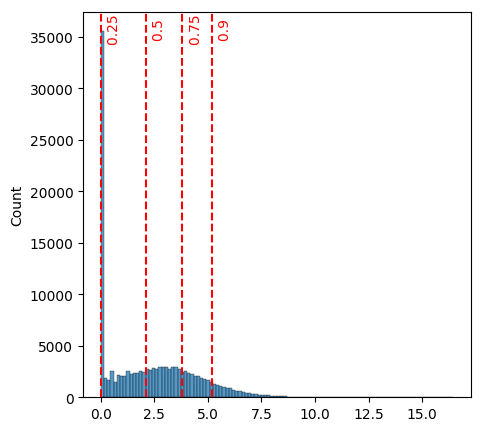

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.histplot(omics_data.values.flatten(),ax=axs)

for quantile in [0.25, 0.5, 0.75, 0.9]:
    quantile_value = pd.Series(omics_data.values.flatten()).quantile(quantile)
    axs.axvline(quantile_value, color='red', linestyle='--')
    axs.text(quantile_value + 0.3, 36000, f'{quantile} ', rotation=90, verticalalignment='center', horizontalalignment='left', color='red')

For this example, the **Local T2** approach will be used. 
While literature suggests using the 25th and 75th percentiles for global thresholds, the 25th percentile in this case is zero. 
Therefore, the 50th percentile will be chosen for the global threshold lower. 
For the local threshold, the 50th percentile will also be used.

To instantiate the `GeneLevelThresholding` class, the following parameters are required:

- `omics_dataframe`: Omics data to be processed in a pandas dataframe format.
- `thresholding_strat`: String containing the thresholding strategy to be used. Must be one of: `global`, `local t1`, `local t2`.
- `global_threshold_lower`: Position of the Global Lower threshold value on the quantile list.
- `global_threshold_upper`: Position of the Global Upper threshold value on the quantile list.
- `local_threshold`: Position of the Local threshold value on the quantile list.

After creating the instance, the original dataset can be transformed by calling the `apply_thresholding_filter` method. This will return a new pandas dataframe with the TAS value for each gene for each sample.


In [6]:
threshold = GeneLevelThresholding(omics_dataframe=omics_data,   
                              thresholding_strat='local t2',
                              global_threshold_lower=2,
                              global_threshold_upper=3,
                              local_threshold=2)

omics_data_after = threshold.apply_thresholding_filter()
omics_data_after

,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001461,ENSG00000001497,ENSG00000001561,...,ENSG00000271321,ENSG00000271605,ENSG00000272047,ENSG00000272325,ENSG00000272333,ENSG00000272414,ENSG00000272573,ENSG00000272968,ENSG00000273045,ENSG00000273079
Lung_Healthy_local_t2_2_3_2,1.814482,-1.335627,2.063823,2.027281,1.773921,1.299193,1.529274,1.405438,1.669240,1.514967,...,-2.783525,1.322385,-0.185317,1.434003,1.280642,1.409690,1.824844,-1.770928,-0.964298,-2.799809
Lung_COVID19_local_t2_2_3_2,1.295191,-0.360486,1.954574,2.165485,1.688855,1.479627,1.763034,1.542111,1.472044,1.689725,...,-2.799809,1.741639,1.047055,1.402621,1.807039,1.747335,-2.799809,-2.799809,-2.799809,-1.762597
Heart_Healthy_local_t2_2_3_2,1.704269,-2.134890,1.003775,2.196666,1.563323,-0.088617,1.121247,1.111025,1.437869,1.217815,...,-2.799809,-0.403717,-0.207555,1.177158,-0.281774,1.456471,2.031305,-2.799809,-2.783525,-2.799809
Heart_COVID19_local_t2_2_3_2,-0.182223,-2.799809,1.436958,1.739284,1.086805,1.244514,-0.137319,1.377554,-0.233258,1.358640,...,-2.799809,-0.048435,-0.522099,1.385763,1.671652,1.857702,-2.799809,-2.799809,-2.799809,-2.456612
Liver_Healthy_local_t2_2_3_2,1.634181,-1.335627,1.067056,2.300672,1.591346,1.526471,1.100511,-0.565902,1.359305,-0.281774,...,-2.799809,-1.335627,-0.520328,-0.088617,-0.309449,1.618685,1.089689,-2.783525,-2.134890,-2.799809
Liver_COVID19_local_t2_2_3_2,-2.799809,-1.470051,-0.267781,1.982849,1.348224,1.245412,1.295361,-0.781233,-0.361629,-0.258079,...,-2.799809,-2.799809,-0.410401,1.026954,1.388856,1.783740,-2.799809,-2.799809,-2.799809,-0.894550
Kidney_Healthy_local_t2_2_3_2,1.688137,-1.770928,1.089689,1.665946,1.691150,1.240087,1.210056,1.267665,1.502969,1.210056,...,-2.799809,-0.520328,-0.164153,1.177158,1.030347,-0.520328,1.540209,-2.783525,-0.338858,-2.799809
Kidney_COVID19_local_t2_2_3_2,-2.799809,-2.799809,1.411853,1.628488,1.277598,-0.404038,1.291098,1.005523,1.220175,-0.591504,...,-2.799809,-0.299736,-1.315568,1.032301,1.424958,1.217090,-2.799809,-2.799809,-0.099004,-2.799809
Intestine_Healthy_local_t2_2_3_2,1.787267,-1.187921,1.364242,1.891213,1.734880,1.600066,1.396752,1.401126,1.624606,1.247197,...,-2.799809,1.003775,-0.338858,1.225402,1.280642,1.493623,1.745864,-2.134890,-0.615737,-2.799809
Intestine_COVID19_local_t2_2_3_2,1.454986,-0.305352,1.227989,2.094752,1.750118,1.558014,1.604128,1.583940,1.691716,1.708668,...,-2.799809,1.343583,1.465505,1.661503,1.810650,1.784586,-2.799809,-2.799809,-2.799809,-1.708034


In [7]:
omics_data_after.T.describe()

,Lung_Healthy_local_t2_2_3_2,Lung_COVID19_local_t2_2_3_2,Heart_Healthy_local_t2_2_3_2,Heart_COVID19_local_t2_2_3_2,Liver_Healthy_local_t2_2_3_2,Liver_COVID19_local_t2_2_3_2,Kidney_Healthy_local_t2_2_3_2,Kidney_COVID19_local_t2_2_3_2,Intestine_Healthy_local_t2_2_3_2,Intestine_COVID19_local_t2_2_3_2
count,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000
mean,0.210204,0.115331,-0.253386,-0.450770,-0.456926,-0.594391,-0.068994,-0.671451,0.147762,0.134550
std,1.816266,1.971881,1.834344,2.000691,1.844206,1.821033,1.798107,1.842559,1.804186,1.933783
min,-2.799809,-2.799809,-2.799809,-2.799809,-2.799809,-2.799809,-2.799809,-2.799809,-2.799809,-2.799809
25%,-1.335627,-2.799809,-2.783525,-2.799809,-2.783525,-2.799809,-1.770928,-2.799809,-1.522146,-2.124483
50%,1.232824,1.283814,-0.143974,-0.212447,-0.370203,-0.345840,-0.010219,-0.461078,1.177158,1.259995
75%,1.677290,1.728286,1.456471,1.500194,1.387810,1.254189,1.517888,1.263318,1.618685,1.752107
max,2.873319,2.842986,3.000389,2.880460,2.956290,2.934997,2.968135,2.998719,2.939181,2.891537


### 3. Run FastCORE

A typical reconstruction workflow follows two main steps. The first is to attribute a score to each reaction of the model, in accordance with the omics data imputed. The second is to use the scores and apply an integration method to select a subset of reactions to build the final model.

The integration scoring methods implemented in *Troppo* are:
- continuous: `ContinuousScoreIntegrationStrategy`
- threshold: `ThresholdSelectionIntegrationStrategy`
- default_core: `DefaultCoreIntegrationStrategy`
- adjusted_score: `AdjustedScoreIntegrationStrategy`
- custom: `CustomSelectionIntegrationStrategy`

The omics integration methods implemented in *Troppo* are:
- gimme: `GIMME`
- tinit: `tINIT`
- fastcore: `FASTcore`
- imat: `IMAT`
- swiftcore: `SWIFTCORE`
- corda: `CORDA`

Note that the appropriate integration scoring method can differ between integration algorithms, but this pipeline can be easily addapted for other integrations algorithms.

To simplify the process, and to allow for the integration of multiple samples using multiprocessing, it is possible to use the `run_from_omics` method from the `ReconstructionWrapper` class. 
This method first Mapps the gene IDs on the omics data to the gene IDs on the model an calculates scores for each reaction based on the Gene-Protein Rules. It then intregrates those scores using custom or predifined functions, and finally it runs the reconstruction algorithm selected.

To be able to run this function the following steps must be carried out:

#### Create a model wrapper.

The `ModelBasedWrapper` class is used to wrap the model so that it can be used by *Troppo*.

Relevant arguments from this class include:
- `model`: the model to be wrapped.
- `ttg_ratio`: the ratio between the number of reactions to be selected and the total number of reactions in the model.
- `gpr_gene_parse_function`: a function that parses the GPRs of the model. This is used to map the identifiers in the omics data to the identifiers in the model.

Important attributes from this class include:
- `model_reader`: a COBRAModelObjectReader instance containing all the information of the model, such as, reaction_ids, metabolite_ids, GPRs, bounds, etc.
- `S`: the stoichiometric matrix of the model.
- `lb`: the lower bounds of the reactions in the model.
- `ub`: the upper bounds of the reactions in the model.

In this specific example we will use the `ReconstructionWrapper` class instead of the base `ModelBasedWrapper` class.

In [8]:
# Define the parsing rules for the GPRs that will be used on the wrapper.
patt = re.compile('__COBAMPGPRDOT__[0-9]{1}')
replace_alt_transcripts = lambda x: patt.sub('', x)

In [9]:
model_wrapper = ReconstructionWrapper(model=model, ttg_ratio=9999, gpr_gene_parse_function=replace_alt_transcripts)
model_wrapper

C:\Users\biosy\anaconda3\envs\troppo\lib\site-packages\cobamp-0.2.1-py3.8.egg\cobamp\gpr\core.py:41: UserWarning: Could not normalize this rule: _ENSG00000131069
  warnings.warn('Could not normalize this rule: ' + rule)
C:\Users\biosy\anaconda3\envs\troppo\lib\site-packages\cobamp-0.2.1-py3.8.egg\cobamp\gpr\core.py:41: UserWarning: Could not normalize this rule: _ENSG00000111058 or _ENSG00000154930
  warnings.warn('Could not normalize this rule: ' + rule)
C:\Users\biosy\anaconda3\envs\troppo\lib\site-packages\cobamp-0.2.1-py3.8.egg\cobamp\gpr\core.py:41: UserWarning: Could not normalize this rule: _ENSG00000091140 and _ENSG00000110435 and _ENSG00000131828 and _ENSG00000150768 and _ENSG00000163114 and _ENSG00000168291
  warnings.warn('Could not normalize this rule: ' + rule)
C:\Users\biosy\anaconda3\envs\troppo\lib\site-packages\cobamp-0.2.1-py3.8.egg\cobamp\gpr\core.py:41: UserWarning: Could not normalize this rule: _ENSG00000111716 or _ENSG00000134333 or _ENSG00000151116 or _ENSG00000

C:\Users\biosy\anaconda3\envs\troppo\lib\site-packages\cobamp-0.2.1-py3.8.egg\cobamp\gpr\core.py:41: UserWarning: Could not normalize this rule: _ENSG00000162365 or _ENSG00000187048
  warnings.warn('Could not normalize this rule: ' + rule)
C:\Users\biosy\anaconda3\envs\troppo\lib\site-packages\cobamp-0.2.1-py3.8.egg\cobamp\gpr\core.py:41: UserWarning: Could not normalize this rule: _ENSG00000108839
  warnings.warn('Could not normalize this rule: ' + rule)
C:\Users\biosy\anaconda3\envs\troppo\lib\site-packages\cobamp-0.2.1-py3.8.egg\cobamp\gpr\core.py:41: UserWarning: Could not normalize this rule: _ENSG00000008394 or _ENSG00000065621 or _ENSG00000084207 or _ENSG00000085871 or _ENSG00000099984 or _ENSG00000100577 or _ENSG00000133433 or _ENSG00000134184 or _ENSG00000134201 or _ENSG00000134202 or _ENSG00000143198 or _ENSG00000148344 or _ENSG00000148834 or _ENSG00000163106 or _ENSG00000168765 or _ENSG00000170899 or _ENSG00000174156 or _ENSG00000182793 or _ENSG00000197448 or _ENSG0000021336

C:\Users\biosy\anaconda3\envs\troppo\lib\site-packages\cobamp-0.2.1-py3.8.egg\cobamp\gpr\core.py:41: UserWarning: Could not normalize this rule: _ENSG00000113273
  warnings.warn('Could not normalize this rule: ' + rule)
C:\Users\biosy\anaconda3\envs\troppo\lib\site-packages\cobamp-0.2.1-py3.8.egg\cobamp\gpr\core.py:41: UserWarning: Could not normalize this rule: _ENSG00000049860 or _ENSG00000068001 or _ENSG00000106302 or _ENSG00000106304 or _ENSG00000114378 or _ENSG00000169660 or _ENSG00000186792 or _ENSG00000213614
  warnings.warn('Could not normalize this rule: ' + rule)
C:\Users\biosy\anaconda3\envs\troppo\lib\site-packages\cobamp-0.2.1-py3.8.egg\cobamp\gpr\core.py:41: UserWarning: Could not normalize this rule: _ENSG00000133116 or _ENSG00000169919
  warnings.warn('Could not normalize this rule: ' + rule)
C:\Users\biosy\anaconda3\envs\troppo\lib\site-packages\cobamp-0.2.1-py3.8.egg\cobamp\gpr\core.py:41: UserWarning: Could not normalize this rule: _ENSG00000010404
  warnings.warn('C

C:\Users\biosy\anaconda3\envs\troppo\lib\site-packages\cobamp-0.2.1-py3.8.egg\cobamp\gpr\core.py:41: UserWarning: Could not normalize this rule: _ENSG00000003989 or _ENSG00000092068 or _ENSG00000103257 or _ENSG00000123643 or _ENSG00000139514 or _ENSG00000149150 or _ENSG00000155465 or _ENSG00000165349 or _ENSG00000167703
  warnings.warn('Could not normalize this rule: ' + rule)
C:\Users\biosy\anaconda3\envs\troppo\lib\site-packages\cobamp-0.2.1-py3.8.egg\cobamp\gpr\core.py:41: UserWarning: Could not normalize this rule: _ENSG00000137860 or _ENSG00000197506
  warnings.warn('Could not normalize this rule: ' + rule)
C:\Users\biosy\anaconda3\envs\troppo\lib\site-packages\cobamp-0.2.1-py3.8.egg\cobamp\gpr\core.py:41: UserWarning: Could not normalize this rule: _ENSG00000130164
  warnings.warn('Could not normalize this rule: ' + rule)
C:\Users\biosy\anaconda3\envs\troppo\lib\site-packages\cobamp-0.2.1-py3.8.egg\cobamp\gpr\core.py:41: UserWarning: Could not normalize this rule: (_ENSG000001018

C:\Users\biosy\anaconda3\envs\troppo\lib\site-packages\cobamp-0.2.1-py3.8.egg\cobamp\gpr\core.py:41: UserWarning: Could not normalize this rule: _ENSG00000064763 or _ENSG00000197601
  warnings.warn('Could not normalize this rule: ' + rule)


#### Create OmicsContainers instances for each sample of the omics data.

The `TabularReader` class is used to read and store the omics data in a container that can then be used by *Troppo*. 

Relevant arguments from the `TabularReader` class:
- `path_or_df`: the omics data can be either a pandas dataframe or a path to a dataset file. The file can be in any format supported by pandas.
- `index_col`: the name of the column that contains the identifiers of the genes.
- `sample_in_rows`: a boolean indicating whether the samples are in rows or columns.
- `header_offset`: the number of rows to skip before reading the header.
- `omics_type`: a string containing the type of omics data. This is used to select the appropriate integration method.
- `nomenclature`: a string containing the nomenclature of the identifiers in the omics data. This is used to map the identifiers to the identifiers in the model.

The `to_containers()` method returns a list of containers, one for each sample of the dataset.

In [ ]:
omics_container = TabularReader(path_or_df=omics_data_after, nomenclature='entrez_id', omics_type='transcriptomics').to_containers()
omics_container

#### Parameters for the reconstruction

In order to batch run the fastcore algorithm, we need to define the parameters that will be used in the reconstruction function. 

In this case, the parameters are:
- `Threshold`: the threshold to be used in the integration method.
- `Reconstruction_wrapper`: the model wrapper to be used.
- `Algorithm`: the algorithm to be used.

Since we perform previously a gene-level thresholding on the omics data, the value of the threshold can be set to 0. This means that we will be selecting reactions whose genes have a positive TAS value.

In [11]:
parameters = {'threshold': 0, 'reconstruction_wrapper': model_wrapper, 'algorithm': 'fastcore'}

#### Reconstruction of Context-Specific models using `run_from_omics`

In order to better understand which parameters are required for the `run_from_omics` function it is important to first consider the different steps it performs for each sample.

##### 1. **Create a data map**:

For this, the `get_integrated_data_map()` method from the `TabularReader` class is used. This maps the gene ids in the omics dataset reaction ids in the model through their GPRs, and attributes a score to each reaction in accordance with the expression values of the associated genes. This method returns a dictionary with the reaction ids as keys and the scores as values.

Important arguments from this method include:

- `model_reader`: a COBRAModelObjectReader instance containing all the information of the model. It can be accessed through the `model_wrapper.model_reader`.
- `and_func`: a function that is used to combine the scores of the genes associated with a reaction for AND rules in the GPR. In this example, we will be using the minimum function, which means that the score of a reaction with AND in their GPRs will be the minimum score of the genes associated with it.
- `or_func`: a function that is used to combine the scores of the genes associated with a reaction for OR rules in the GPR. In this example, we will be using the sum function, which means that the score of a reaction with OR in their GPRs will be the sum of the scores of the genes associated with it.

##### 2. **Integrate Scores**: 

For FastCORE, a custom integration strategy will be used. 
The goal is to return a list of reactions whose calculated score is above the defined threshold.

While the `ThresholdSelectionIntegrationStrategy` class could achieve this, a custom strategy was selected to also include a set of reactions to be protected during the integration.

For this, the `CustomSelectionIntegrationStrategy` class will be utilized. This class allows the user to insert a custom function to integrate the scores. In this case, the custom function will be named `integration_fx`, and it must be passed for the `run_from_omics` method as the following tuple `('CustomSelectionIntegrationStrategy', [integration_fx])`.

##### 3. Running the `FastCORE` Reconstruction Algorithm

The `run_from_omics` method will also require parameters for the reconstruction algorithm to be passed along. These will be divided into two sets of parameters: those for the properties class and those for the algorithm class. For the `FastCORE` algorithm, these are:

**`FastcoreProperties`**

- `core`: List of indexes of core reactions as determined by integrated scores.
- `flux_threshold`: Flux threshold for the algorithm.
- `solver`: Solver to be used.

**`FASTcore`**

- `S`: The stoichiometric matrix of the model, accessible via `model_wrapper.S`.
- `lb`: The lower bounds of the reactions, accessible via `model_wrapper.lb`.
- `ub`: The upper bounds of the reactions, accessible via `model_wrapper.ub`.
- `properties`: A `FastcoreProperties` instance containing the algorithm properties.

Note that these parameters will differ based on the selected algorithm.

##### Parameters required for the `run_from_omics` function:

- `omics_data`: The omics data container for the sample.
- `algorithm`: A string specifying the algorithm for reconstruction.
- `and_or_funcs`: A tuple with functions for the AND and OR operations of the GPR.
- `integration_strategy`: A tuple with the integration strategy and the function to apply to the scores.
- `solver`: The solver for optimization.
- `**kwargs`: Additional parameters specific to the algorithm used.

##### Output
The `run_from_omics` method returns a dictionary containing all model reactions with their respective Boolean value, indicating whether the reaction is active in the model.
Note that this function will run for each sample individually, hence the dictionary will only contain the results for one sample.

In [ ]:
def reconstruction_function_fastcore(omics_container, parameters: dict):

    protected_reactions = ['biomass_human']
    
    def integration_fx(reaction_map_scores):
        return [[k for k, v in reaction_map_scores.get_scores().items() if (v is not None and v > threshold) or k in 
                 protected_reactions]]

    
    threshold, rec_wrapper, method = [parameters[parameter] for parameter in
                                      ['threshold', 'reconstruction_wrapper', 'algorithm']]

    AND_OR_FUNCS = (min, sum)    

    if method == 'fastcore':
            return rec_wrapper.run_from_omics(omics_data=omics_container, algorithm=method, and_or_funcs=AND_OR_FUNCS ,
                                              integration_strategy=('custom', [integration_fx]) ,solver='CPLEX')

Note that in this case, we are defining a function that will use the `run_from_omics` method. 
This is because the goal is to apply a parallelization method to allow for multiple sample integration. 
If the goal were only to reconstruct a context-specific model for one sample, calling `rec_wrapper.run_from_omics()` would suffice.

#### Run in Batch

Using the `reconstruction_function_fastcore` defined above, we can run the FastCORE algorithm in batch for multiple samples. This can be achieved by using the `batch_run` function from *Cobamp*, which is compatible with *Troppo*.

For this, the required parameters are:

- `function`: The function to be parallelized.
- `sequence`: The sequence where the parallelized function is to be applied.
- `paramargs`: The specific parameters of the function.
- `threads`: The number of threads to use for parallelization.

In [13]:
batch_fastcore_res = batch_run(reconstruction_function_fastcore, omics_container, parameters, threads=2)
batch_fastcore_res

[{'HMR_4097': True,
  'HMR_4099': True,
  'HMR_4108': True,
  'HMR_4133': True,
  'HMR_4137': True,
  'HMR_4281': False,
  'HMR_4388': False,
  'HMR_4283': True,
  'HMR_8357': True,
  'HMR_4379': True,
  'HMR_4301': True,
  'HMR_4355': True,
  'HMR_4358': False,
  'HMR_4360': False,
  'HMR_4363': True,
  'HMR_4365': True,
  'HMR_4368': True,
  'HMR_4370': True,
  'HMR_4371': True,
  'HMR_4372': True,
  'HMR_4373': True,
  'HMR_4375': True,
  'HMR_4377': True,
  'HMR_4381': True,
  'HMR_4391': True,
  'HMR_4394': True,
  'HMR_4396': True,
  'HMR_4521': False,
  'HMR_6410': False,
  'HMR_6412': False,
  'HMR_7745': True,
  'HMR_7746': True,
  'HMR_7747': True,
  'HMR_7748': True,
  'HMR_7749': True,
  'HMR_4122': True,
  'HMR_5395': True,
  'HMR_5396': True,
  'HMR_9727': True,
  'HMR_5397': True,
  'HMR_5398': True,
  'HMR_5399': False,
  'HMR_5400': False,
  'HMR_5401': True,
  'HMR_8585': False,
  'HMR_3944': False,
  'HMR_4128': True,
  'HMR_4130': True,
  'HMR_4131': True,
  'HMR_41

In [14]:
# Parse the results to display as a pandas dataframe
fastcore_res_dict = dict(zip([('fastcore', container.condition) for container in omics_container], batch_fastcore_res))
fastcore_df = pd.DataFrame.from_dict(fastcore_res_dict, orient='index')
fastcore_df

HMR_4097  HMR_4099  HMR_4108  \
fastcore Lung_Healthy_local_t2_2_3_2           True      True      True   
         Lung_COVID19_local_t2_2_3_2           True      True      True   
         Heart_Healthy_local_t2_2_3_2          True      True      True   
         Heart_COVID19_local_t2_2_3_2          True      True      True   
         Liver_Healthy_local_t2_2_3_2         False      True     False   
         Liver_COVID19_local_t2_2_3_2          True      True      True   
         Kidney_Healthy_local_t2_2_3_2        False      True     False   
         Kidney_COVID19_local_t2_2_3_2         True      True      True   
         Intestine_Healthy_local_t2_2_3_2      True      True      True   
         Intestine_COVID19_local_t2_2_3_2      True      True      True   

                                           HMR_4133  HMR_4137  HMR_4281  \
fastcore Lung_Healthy_local_t2_2_3_2           True      True     False   
         Lung_COVID19_local_t2_2_3_2           True      True     False   
         Heart_Healthy_local_t2_2_3_2          True      True     False   
         Heart_COVID19_local_t2_2_3_2          True      True     False   
         Liver_Healthy_local_t2_2_3_2         False      True      True   
         Liver_COVID19_local_t2_2_3_2          True      True     False   
         Kidney_Healthy_local_t2_2_3_2        False      True      True   
         Kidney_COVID19_local_t2_2_3_2         True      True     False   
         Intestine_Healthy_local_t2_2_3_2      True      True     False   
         Intestine_COVID19_local_t2_2_3_2      True      True     False   

                                           HMR_4388  HMR_4283  HMR_8357  \
fastcore Lung_Healthy_local_t2_2_3_2          False      True      True   
         Lung_COVID19_local_t2_2_3_2          False     False      True   
         Heart_Healthy_local_t2_2_3_2         False     False      True   
         Heart_COVID19_local_t2_2_3_2         False      True      True   
         Liver_Healthy_local_t2_2_3_2         False     False      True   
         Liver_COVID19_local_t2_2_3_2         False     False      True   
         Kidney_Healthy_local_t2_2_3_2        False     False      True   
         Kidney_COVID19_local_t2_2_3_2        False     False      True   
         Intestine_Healthy_local_t2_2_3_2     False     False      True   
         Intestine_COVID19_local_t2_2_3_2     False     False      True   

                                           HMR_4379  ...  HMR_10119  \
fastcore Lung_Healthy_local_t2_2_3_2           True  ...      False   
         Lung_COVID19_local_t2_2_3_2           True  ...      False   
         Heart_Healthy_local_t2_2_3_2          True  ...      False   
         Heart_COVID19_local_t2_2_3_2          True  ...      False   
         Liver_Healthy_local_t2_2_3_2          True  ...       True   
         Liver_COVID19_local_t2_2_3_2          True  ...       True   
         Kidney_Healthy_local_t2_2_3_2         True  ...      False   
         Kidney_COVID19_local_t2_2_3_2         True  ...      False   
         Intestine_Healthy_local_t2_2_3_2      True  ...      False   
         Intestine_COVID19_local_t2_2_3_2      True  ...      False   

                                           HMR_10120  HMR_10121  HMR_10122  \
fastcore Lung_Healthy_local_t2_2_3_2           False      False      False   
         Lung_COVID19_local_t2_2_3_2           False      False      False   
         Heart_Healthy_local_t2_2_3_2          False      False      False   
         Heart_COVID19_local_t2_2_3_2          False      False      False   
         Liver_Healthy_local_t2_2_3_2           True      False      False   
         Liver_COVID19_local_t2_2_3_2           True      False      False   
         Kidney_Healthy_local_t2_2_3_2         False      False      False   
         Kidney_COVID19_local_t2_2_3_2         False      False      False   
         Intestine_Healthy_local_t2_2_3_2      False      False      False   
   